In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

warnings.filterwarnings("ignore")

In [6]:
df = pd.read_csv('superstore_forecasting_dataset.csv')
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [15]:
def run_arima_forecast(category_label: str, country_label: str, main_df: pd.DataFrame, forecast_type: str ="category_country"):
    ts = pd.Series()
    title_suffix = ""
    search_label = ""

    if forecast_type == "total_overall":
        print(f"\n📈 Total Sales Forecasting (All Categories & Countries)")
        ts = main_df.groupby(pd.Grouper(key='Order Date', freq='MS'))['Sales'].sum()
        title_suffix = "Total Monthly Sales"
        search_label = "Total Sales"
    elif forecast_type == "total_category":
        if category_label is None:
            print("Error: category_label must be provided for 'total_category' forecast_type.")
            return
        print(f"\n📈 Total {category_label} Sales Forecasting (All Countries)")
        df_filtered = main_df[main_df['Category'] == category_label]
        ts = df_filtered.groupby(pd.Grouper(key='Order Date', freq='MS'))['Sales'].sum()
        title_suffix = f"Total {category_label} Monthly Sales"
        search_label = f"Total {category_label} Sales"
    elif forecast_type == "category_country":
        if category_label is None or country_label is None:
            print("Error: category_label and country_label must be provided for 'category_country' forecast_type.")
            return
        print(f"\n📦 Category: {category_label}, Country: {country_label}")
        df_filtered = main_df[(main_df['Category'] == category_label) & (main_df['Country'] == country_label)]
        ts = df_filtered.groupby(pd.Grouper(key='Order Date', freq='MS'))['Sales'].sum()
        title_suffix = f"{category_label} in {country_label} Monthly Sales"
        search_label = f"{category_label} in {country_label}"
    else:
        print(f"Error: Invalid forecast_type '{forecast_type}'.")
        return

    ts = ts.dropna()
    ts = ts[ts.index >= '2014-01-01']

    if ts.empty:
        print(f"Skipping {search_label}: No sales data available for the specified period.")
        return
    if len(ts) < 24:
        print(f"Skipping {search_label}: Not enough data points ({len(ts)}) for effective seasonal forecasting. At least 24 recommended.")
        return

    plt.figure(figsize=(12, 4))
    plt.plot(ts, label='Historical Monthly Sales', color='blue')
    plt.title(title_suffix)
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

    best_aic = np.inf
    best_model = None
    best_param = None
    best_seasonal = None

    print(f"Searching for optimal SARIMA parameters for {search_label} (this may take a moment)...")
    for param in pdq:
        for seasonal in seasonal_pdq:
            try:
                model = sm.tsa.statespace.SARIMAX(ts,
                                                  order=param,
                                                  seasonal_order=seasonal,
                                                  enforce_stationarity=False,
                                                  enforce_invertibility=False)
                result = model.fit(disp=False, maxiter=100)
                
                if result.aic < best_aic:
                    best_aic = result.aic
                    best_model = result
                    best_param = param
                    best_seasonal = seasonal
            except Exception as e:
                # print(f"Error fitting ARIMA{param}x{seasonal} for {search_label}: {e}")
                continue

    if best_model is None:
        print(f"❌ No valid SARIMA model found for {search_label} after grid search. Skipping forecast.")
        return

    print(f"✅ Best SARIMA Model for {search_label}: ARIMA{best_param}x{best_seasonal} - AIC: {best_aic:.2f}")
    # print(best_model.summary())

    in_sample_pred = best_model.predict(start=ts.index[0], end=ts.index[-1])

    plt.figure(figsize=(14, 5))
    plt.plot(ts, label='Historical Sales (Actual)', color='blue')
    plt.plot(in_sample_pred, label='In-sample Forecast (Fitted)', color='purple', linestyle=':')
    plt.title(f"{search_label} - In-sample Forecast (Model Fit)")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    print(f"In-sample forecast for {search_label} (how well the model fits past data):")
    # print(in_sample_pred)


    n_forecast = 12
    forecast_results = best_model.get_forecast(steps=n_forecast)
    forecast_mean = forecast_results.predicted_mean
    forecast_ci = forecast_results.conf_int()

    forecast_index = pd.date_range(ts.index[-1] + pd.DateOffset(months=1), periods=n_forecast, freq='MS')
    forecast_series = pd.Series(forecast_mean, index=forecast_index)
    lower_bound = pd.Series(forecast_ci.iloc[:, 0], index=forecast_index)
    upper_bound = pd.Series(forecast_ci.iloc[:, 1], index=forecast_index)

    print(f"Forecast for the next {n_forecast} months for {search_label} (Out-of-sample):")
    # print(forecast_series)

    plt.figure(figsize=(14, 5))
    plt.plot(ts, label='Historical Sales', color='blue')
    plt.plot(forecast_series, label='Forecasted Sales', color='red', linestyle='--')
    plt.fill_between(forecast_index,
                     lower_bound,
                     upper_bound,
                     color='pink', alpha=0.3, label='95% Confidence Interval')
    plt.title(f"{search_label} - 12 Month Sales Forecast (Out-of-sample)")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    test_size = 12
    if len(ts) > test_size * 2:
        train = ts[:-test_size]
        test = ts[-test_size:]

        try:
            model_train = sm.tsa.statespace.SARIMAX(train,
                                                    order=best_param,
                                                    seasonal_order=best_seasonal,
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False)
            results_train = model_train.fit(disp=False, maxiter=100)
            pred = results_train.forecast(steps=test_size)

            mae = mean_absolute_error(test, pred)
            rmse = np.sqrt(mean_squared_error(test, pred))

            print(f"\n📊 Accuracy Metrics for {search_label} (last {test_size} months backtest):")
            print(f"🔹 MAE  : {mae:.2f}")
            print(f"🔹 RMSE : {rmse:.2f}")
        except Exception as e:
            print(f"⚠️ Error during backtesting for {search_label}: {e}")
    else:
        print(f"⚠️ Not enough data for backtesting accuracy for {search_label}. Need at least {test_size * 2} data points.")



Identifying unique category-country combinations...
Found 8 unique category-country combinations.

📈 Total Furniture Sales Forecasting (All Countries)


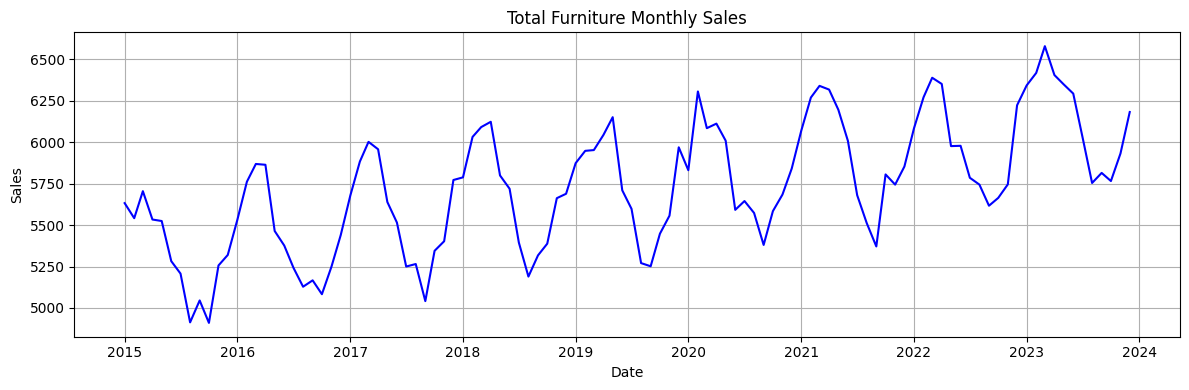

Searching for optimal SARIMA parameters for Total Furniture Sales (this may take a moment)...
✅ Best SARIMA Model for Total Furniture Sales: ARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC: 1005.67


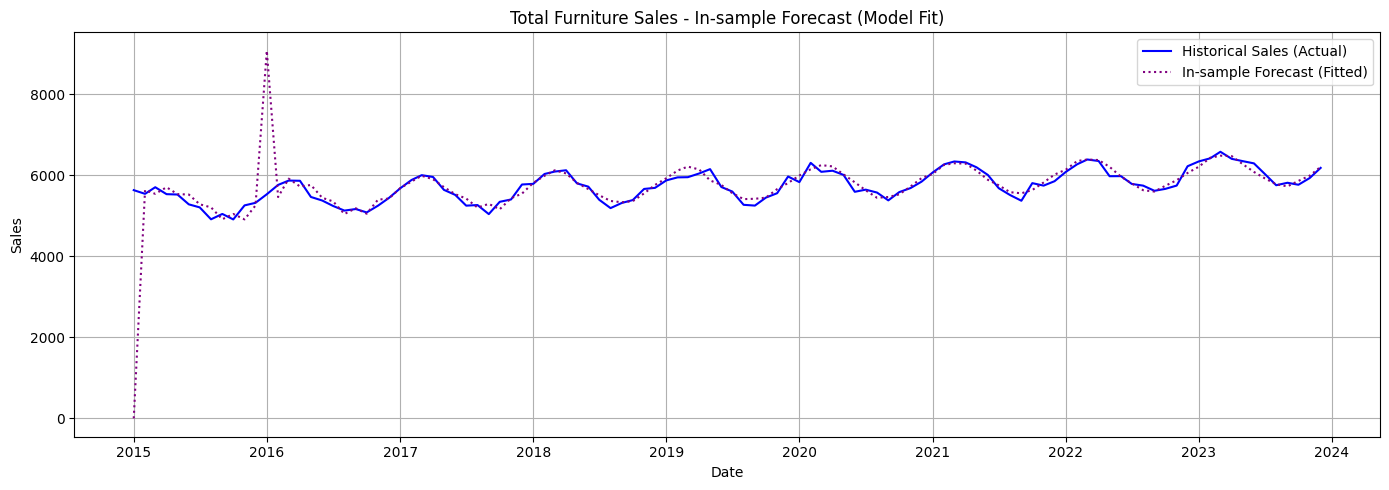

In-sample forecast for Total Furniture Sales (how well the model fits past data):
Forecast for the next 12 months for Total Furniture Sales (Out-of-sample):


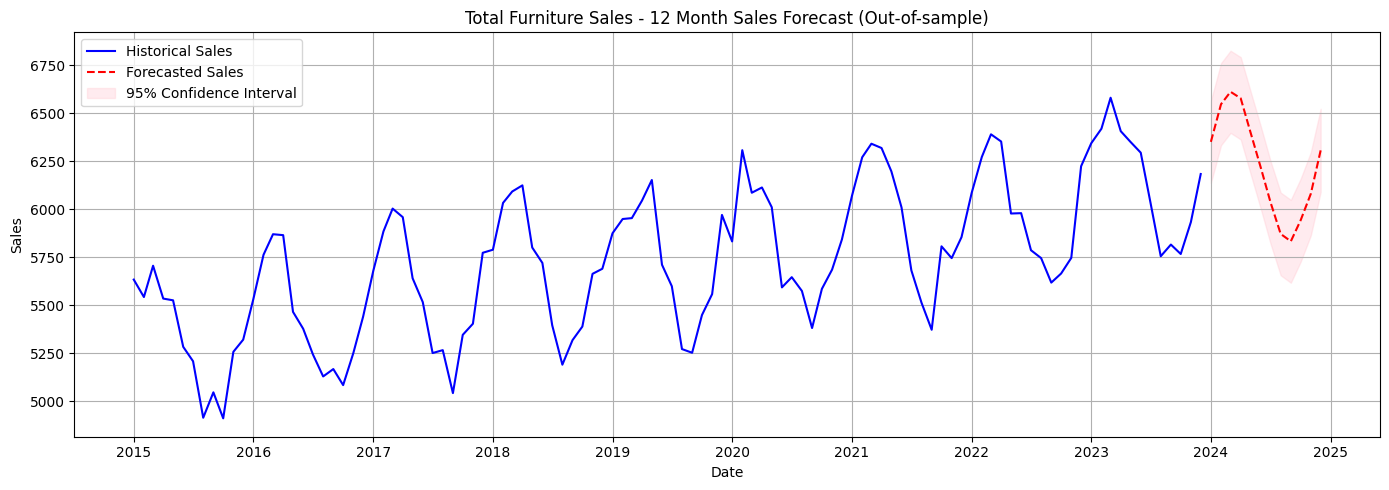


📊 Accuracy Metrics for Total Furniture Sales (last 12 months backtest):
🔹 MAE  : 79.36
🔹 RMSE : 102.32

📈 Total Office Supplies Sales Forecasting (All Countries)


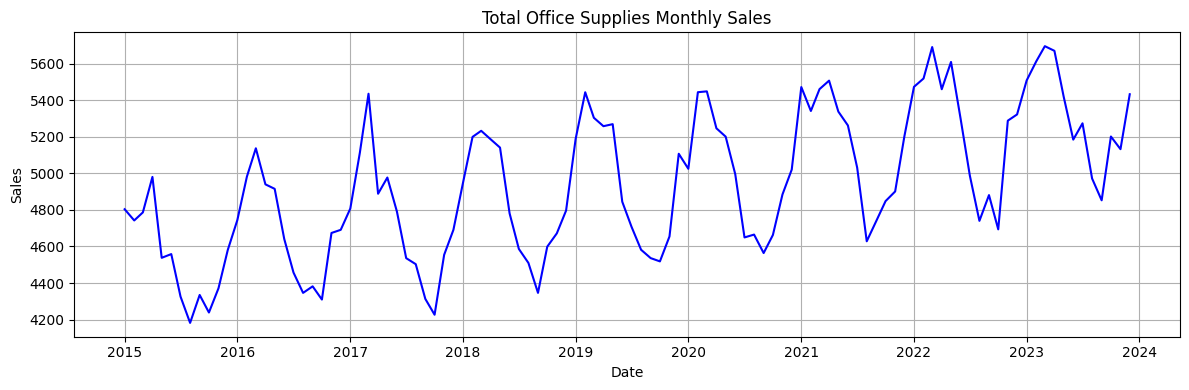

Searching for optimal SARIMA parameters for Total Office Supplies Sales (this may take a moment)...
✅ Best SARIMA Model for Total Office Supplies Sales: ARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC: 1010.37


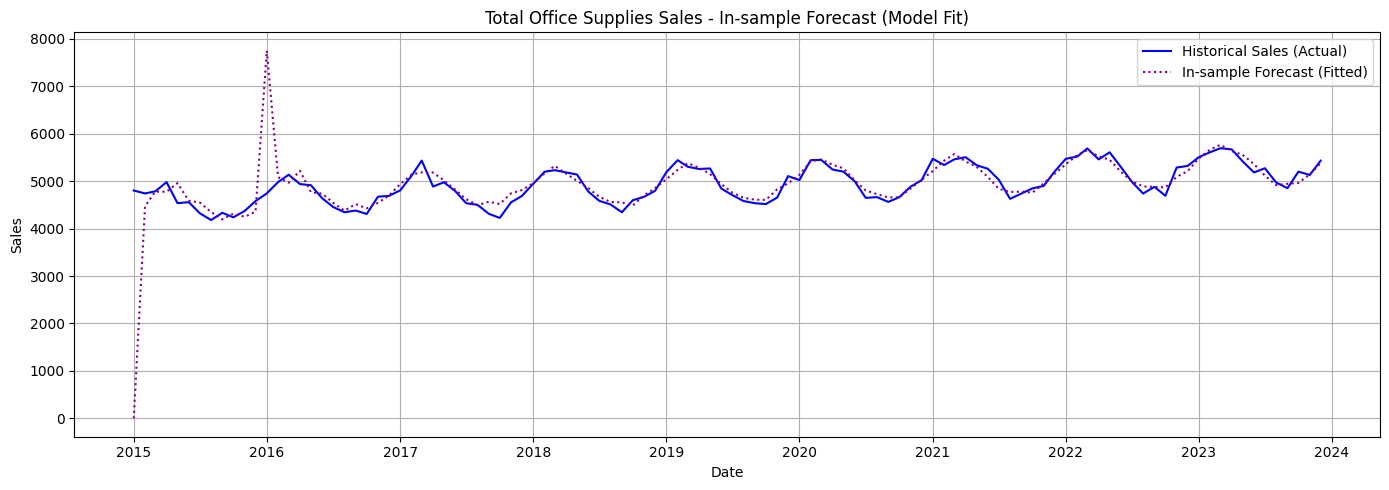

In-sample forecast for Total Office Supplies Sales (how well the model fits past data):
Forecast for the next 12 months for Total Office Supplies Sales (Out-of-sample):


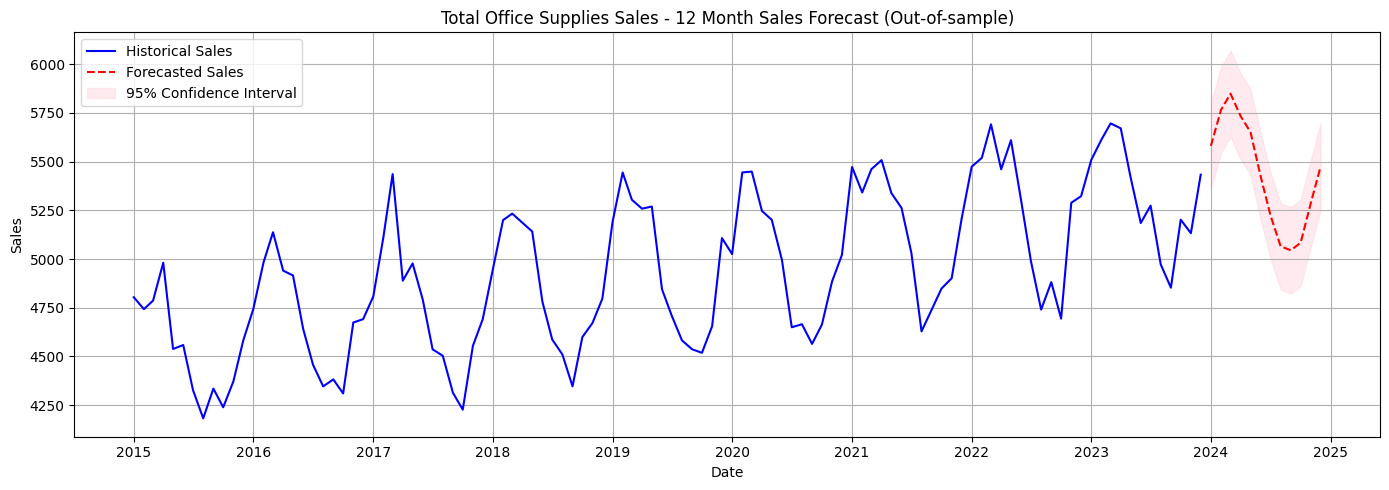


📊 Accuracy Metrics for Total Office Supplies Sales (last 12 months backtest):
🔹 MAE  : 103.79
🔹 RMSE : 127.04

📈 Total Sales Forecasting (All Categories & Countries)


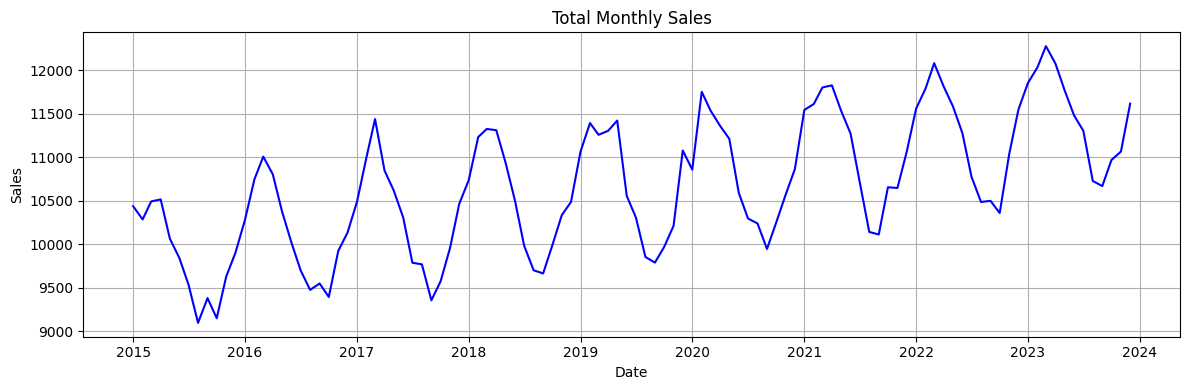

Searching for optimal SARIMA parameters for Total Sales (this may take a moment)...
✅ Best SARIMA Model for Total Sales: ARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC: 1069.18


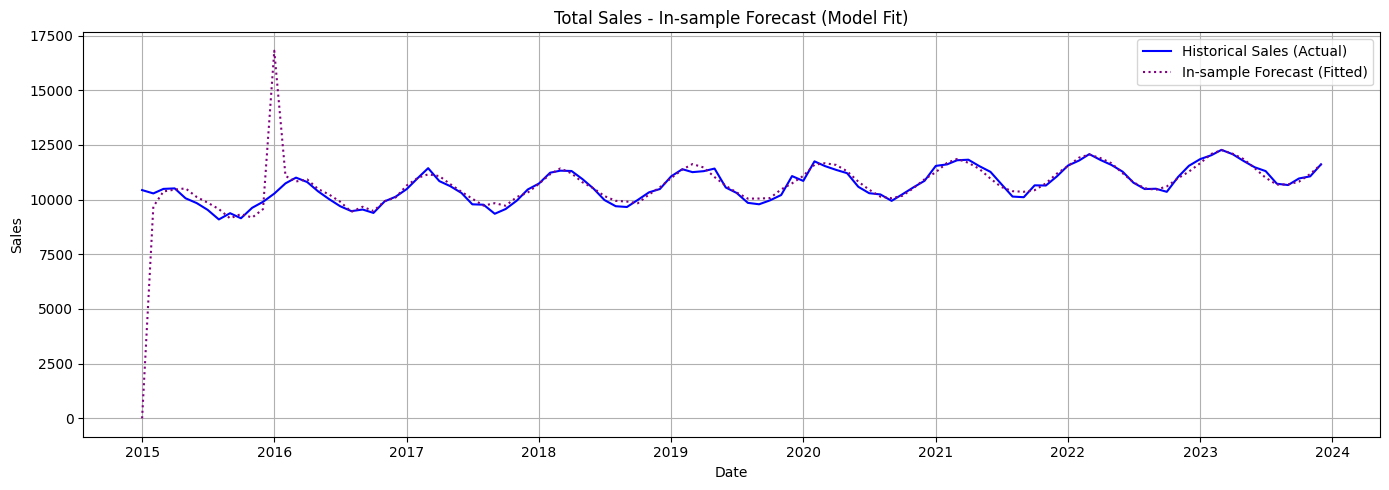

In-sample forecast for Total Sales (how well the model fits past data):
Forecast for the next 12 months for Total Sales (Out-of-sample):


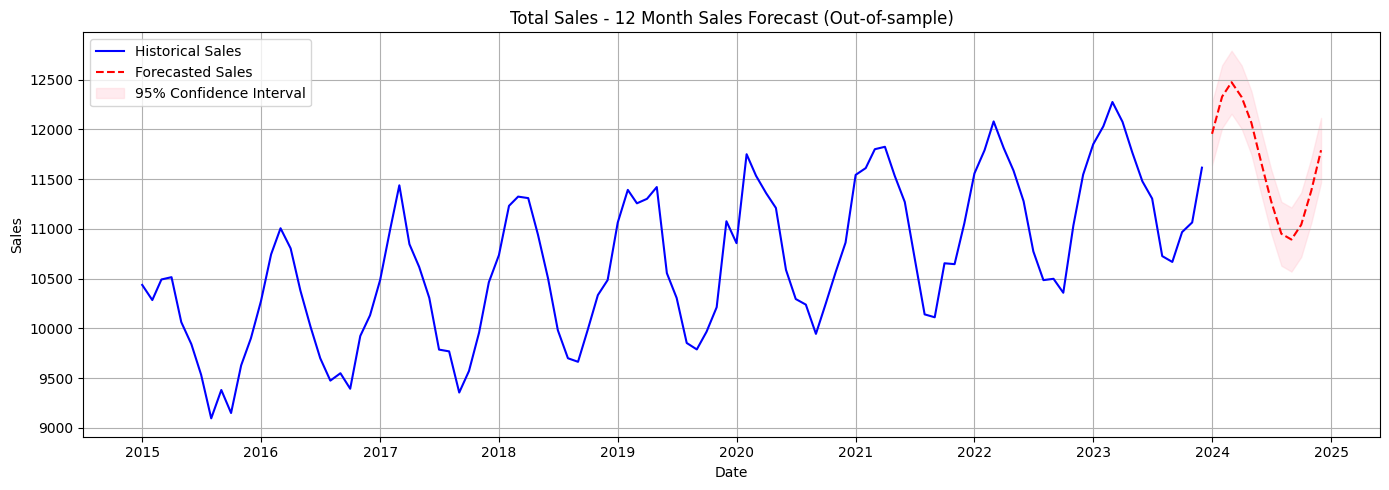


📊 Accuracy Metrics for Total Sales (last 12 months backtest):
🔹 MAE  : 94.32
🔹 RMSE : 125.84

ARIMA forecasting process for all category-country combinations and total sales completed.


In [16]:
print("\nIdentifying unique category-country combinations...")
unique_combinations = df[['Category', 'Country']].drop_duplicates().values

print(f"Found {len(unique_combinations)} unique category-country combinations.")

# for category, country in unique_combinations:
#     run_arima_forecast(category, country, df)

run_arima_forecast(category_label='Furniture', country_label=None, main_df=df, forecast_type="total_category")
run_arima_forecast(category_label='Office Supplies', country_label=None, main_df=df, forecast_type="total_category")

run_arima_forecast(category_label=None, country_label=None, main_df=df, forecast_type="total_overall")

print("\nARIMA forecasting process for all category-country combinations and total sales completed.")
